In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ml-100-marathon-final-exam/sample_submission_new.csv
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/0f3af8d0223fdc3d7477d70f01828dd7.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/6c6fc0a1bd638792e341c75949c76428.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/20310196c1dc449e789449cfbcbd246d.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/9a0091de0db3e032c955dcd4fd9c4443.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/f951d216ab537320621d6e5a676f90f2.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/c3b0f53e9e64c3fa8fb455cb2d61e779.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/93ed14cdf1950f97b01be4f14f7c3969.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/1bf375c3581a49afb46a159499ca6c2b.jpg
/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test/dba5bd6fddf6d753f1f64c6e5e2dc247.jpg
/kaggle/input/2021-ml-100-marathon-fi

In [2]:
train_path = "/kaggle/input/2021-ml-100-marathon-final-exam/image_data/train"
test_path = "/kaggle/input/2021-ml-100-marathon-final-exam/image_data/test"
print(os.listdir(train_path))

# 花朵名稱對應的類別碼
flower_mapping = {"daisy":0, "dandelion":1, "rose":2, "sunflower":3, "tulip":4}
flowers = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, #隨機旋轉角度的上限 (角度值 : 0 ~ 180)
                  width_shift_range=0.2, # 左右隨機平移上限
                  height_shift_range=0.2, # 上下隨機平移上限
                  shear_range=0.2, # 逆時針的剪切變形角度
                  zoom_range=0.2, # 影像倍率放大縮小的上限
                  horizontal_flip=True, # 是否左右翻轉
                  fill_mode="nearest", # 填補周圍空缺方法
                  validation_split=0.2) # 測試集採樣比

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMAGE_SIZE = (240, 320)
BATCH_SIZE = 16

train_generator = train_datagen.flow_from_directory(train_path, # 目標目錄
                           target_size=IMAGE_SIZE, # 所有影象調整為IMAGE_SIZE
                           classes=flowers, 
                           batch_size=BATCH_SIZE, 
                           subset="training") # 設為訓練集

valid_generator = train_datagen.flow_from_directory(train_path, 
                           target_size=IMAGE_SIZE, 
                           classes=flowers, 
                           batch_size=BATCH_SIZE, 
                           subset="validation") # 設為驗證集  

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 載入 ResNet50 預訓練權重，不包括頂層（Top layer，全連接層）
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 320, 3))

# 創建一個新的模型，將 ResNet50 基礎模型添加到其中
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 假設有5個類別
model.summary()
# 使用 Adam optimizer, 使用固定的 learning rate 
model.compile(loss="categorical_crossentropy",
       optimizer=Adam(lr=1e-5),
       metrics=["accuracy"])

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 dense (Dense)               (None, 256)               41943296  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 65532293 (249.99 MB)
Trainable params: 65479173 (249.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [6]:
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
# 訓練模型
# 參考資料: fit_generator: https://blog.csdn.net/dou3516/article/details/118757164
history = model.fit_generator(train_generator, 
          steps_per_epoch=train_generator.samples // BATCH_SIZE,
          epochs=100,
          validation_data=valid_generator, 
          validation_steps=valid_generator.samples // BATCH_SIZE,
          use_multiprocessing=True,
          workers=8,
          verbose=1,
          callbacks=[early_stopping, model_checkpoint])

/tmp/ipykernel_26/2040741575.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
141/141 [==============================] - ETA: 0s - loss: 3.7741 - accuracy: 0.3271

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 92s 320ms/step - loss: 3.7741 - accuracy: 0.3271 - val_loss: 8.8279 - val_accuracy: 0.4018
Epoch 2/100
141/141 [==============================] - 45s 308ms/step - loss: 1.3561 - accuracy: 0.4376 - val_loss: 1.2255 - val_accuracy: 0.4857
Epoch 3/100
141/141 [==============================] - 43s 289ms/step - loss: 1.1738 - accuracy: 0.5009 - val_loss: 1.2660 - val_accuracy: 0.5107
Epoch 4/100
141/141 [==============================] - 46s 312ms/step - loss: 1.0860 - accuracy: 0.5250 - val_loss: 1.1431 - val_accuracy: 0.5214
Epoch 5/100
141/141 [==============================] - 44s 303ms/step - loss: 1.0428 - accuracy: 0.5664 - val_loss: 1.9040 - val_accuracy: 0.4821
Epoch 6/100
141/141 [==============================] - 45s 309ms/step - loss: 0.9660 - accuracy: 0.6159 - val_loss: 1.1415 - val_accuracy: 0.5679
Epoch 7/100
141/141 [==============================] - 43s 292ms/step - loss: 0.9337 - accuracy: 0.6381 - val_loss: 2.0010 - val_accurac

In [7]:
# Collect results
results = {}
results["Fixed LR"] = {'train-loss': history.history["loss"],
             'valid-loss': history.history["val_loss"],
             'train-acc': history.history["accuracy"],
             'valid-acc': history.history["val_accuracy"]}

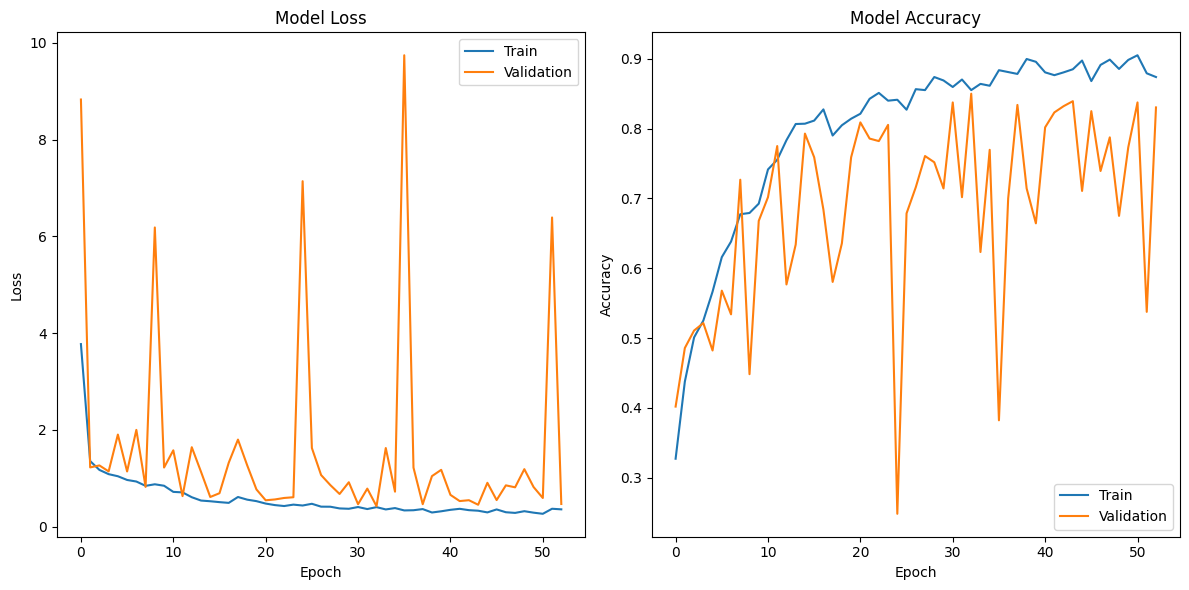

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import pandas as pd
from tqdm import tqdm # 進度條顯示套件 

best_model = load_model("best_model.h5")

# 設定最後的輸出資料
X_test = list()
id_test = []

# 使用 Keras 內建的載入寫法 
def load_image(img_path):
  img = load_img(img_path, target_size=(240, 320))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img 
def make_test_data():
    global X_test
    dir_path = test_path
    for img in tqdm(os.listdir(dir_path)):
        id_test.append(img[:-4])
        path = os.path.join(dir_path, img)
        img = load_image(path)
        img = np.squeeze(img, axis=0)
        X_test.append(np.array(img))
make_test_data()        
X_test = np.array(X_test)

# 輸出預測檔
pred = best_model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)
sub = pd.DataFrame({"id": id_test, "flower_class": pred_digits})
sub.to_csv("ResNet50_flower_2.csv", index = False)

100%|██████████| 2000/2000 [00:19<00:00, 102.19it/s]


63/63 [==============================] - 8s 80ms/step


![ML100day_final.jpg](ML100day_final.jpg)